In [2]:
import multiprocessing

import mne
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import threading
from mne_icalabel import label_components

In [4]:
def preprocess_eeg(p):
    exp_start=p*3
    exp_end=(p+1)*3

    if exp_end > len(experiments):
        exp_end = len(experiments)
        
    for exp in range(exp_start, exp_end, 1):
        exp_data = loadmat(r'D:\SEED_1020\Try\{}'.format(experiments[exp]))
        #各个trial的标签 1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1
        trial_labels = [1,0,-1,-1,0,1,-1,0,1,1,0,-1,0,1,-1]
        for trial_key in exp_data:
            #print(exp_key)
            if trial_key in ['__header__','__version__','__globals__']:
                continue
            trial_data = exp_data[trial_key]
            # 将mat数据和电极信息结合成raw，raw包含数据和电极信息
            raw = mne.io.RawArray(trial_data, info)
            raw.set_eeg_reference()

            #绘制图形查看
            raw.plot(scalings = {'eeg': 50}, block=True, title='可检查并排除坏导')  # 定义坏导
            plt.show()
            # 滤波
            raw.compute_psd().plot()
            plt.show()
            raw.filter(l_freq=1, h_freq=49)  # 带通滤波
            raw.notch_filter(freqs=60)  # 凹陷滤波
            #psd图
            # raw.compute_psd().plot()
            # plt.show()

            # 独立分析法ICA
            ica = mne.preprocessing.ICA()  # 相当于先定义一个ica方法
            # ica = mne.preprocessing.ICA(method='infomax', fit_params=dict(extended=True))
            ica.fit(raw)  # 训练raw

            ic_labels = label_components(raw, ica, method='iclabel')
            labels = ic_labels['labels']
            bad_ICs = [idx for idx, label in enumerate(labels) if label not in ['brain', 'other']]
            print('exclude these bad ICA components: {}'.format(bad_ICs))


            # 可视化每个独立分布的头皮分布
            #ica.plot_components()
            # 绘制mei个独立分布的一些属性
            # pick_id = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # [0,1,2,3,4,5,6,7,8,9]
            # ica.plot_properties(raw, picks=pick_id)

            # ica.plot_sources(raw, show_scrollbars=False, block=True,
            #                  title='请选择需要去除的成分')  # show_scrollbars绘图初始化时是否显示滚动条。
            # plt.show()


            raw = ica.apply(raw, exclude=bad_ICs)  # 把选取的成分去除掉 去除weiji
            raw.plot(scalings = {'eeg': 50}, block=True, title='可检查并排除坏导')  # 定义坏导
            plt.show()


            epochs = mne.make_fixed_length_epochs(raw, duration=1, overlap=0.2)
            #Divide continuous raw data into equal-sized consecutive epochs. seed是200hz,2秒就是400个时间戳
            #epochs.plot()

            # 保存fif格式的数据文件
            trial_label = trial_labels[int(trial_key[-1])-1]
            sub_name = trial_key.split('_')[0]
            eegx = trial_key.split('_')[1]

            exp_trials = 15
            trial_No = int(trial_key.split('_')[1][3:])
            eponame = r'D:\SEED_1020\Tryresult\{}_{}_{}_{}_epo.fif'.format(str(exp*exp_trials+trial_No), sub_name, eegx, trial_label)
            epochs.save(eponame, overwrite=True)

{'Fp1': array([0. , 0.2, 0.1]), 'Fpz': array([0.  , 0.3 , 0.15]), 'Fp2': array([ 0. , -0.2,  0.1]), 'AF3': array([-0.1 ,  0.25,  0.05]), 'AF4': array([0.1 , 0.25, 0.05]), 'F7': array([-0.3,  0. ,  0. ]), 'F5': array([-0.2 ,  0.1 ,  0.05]), 'F3': array([-0.15,  0.2 ,  0.1 ]), 'F1': array([-0.05,  0.3 ,  0.1 ]), 'Fz': array([0.  , 0.35, 0.1 ]), 'F2': array([0.05, 0.3 , 0.1 ]), 'F4': array([0.15, 0.2 , 0.1 ]), 'F6': array([0.2 , 0.1 , 0.05]), 'F8': array([0.3, 0. , 0. ]), 'FT7': array([-0.35, -0.05,  0.  ]), 'FC5': array([-0.25,  0.05,  0.05]), 'FC3': array([-0.2,  0.1,  0.1]), 'FC1': array([-0.1,  0.2,  0.1]), 'FCz': array([0.  , 0.25, 0.1 ]), 'FC2': array([0.1, 0.2, 0.1]), 'FC4': array([0.2, 0.1, 0.1]), 'FC6': array([0.25, 0.05, 0.05]), 'FT8': array([ 0.35, -0.05,  0.  ]), 'T7': array([-0.4,  0. ,  0. ]), 'C5': array([-0.3 ,  0.1 ,  0.05]), 'C3': array([-0.2,  0.2,  0.1]), 'C1': array([-0.1,  0.3,  0.1]), 'Cz': array([0. , 0.4, 0.1]), 'C2': array([0.1, 0.3, 0.1]), 'C4': array([0.2, 0.2,

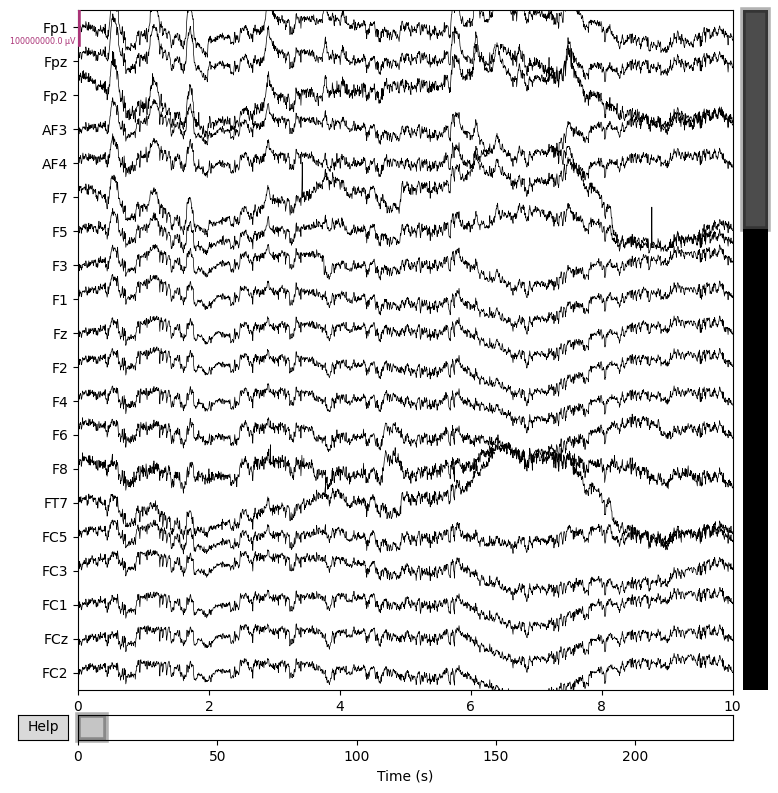

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


D:\Anaconda3\envs\mamba\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


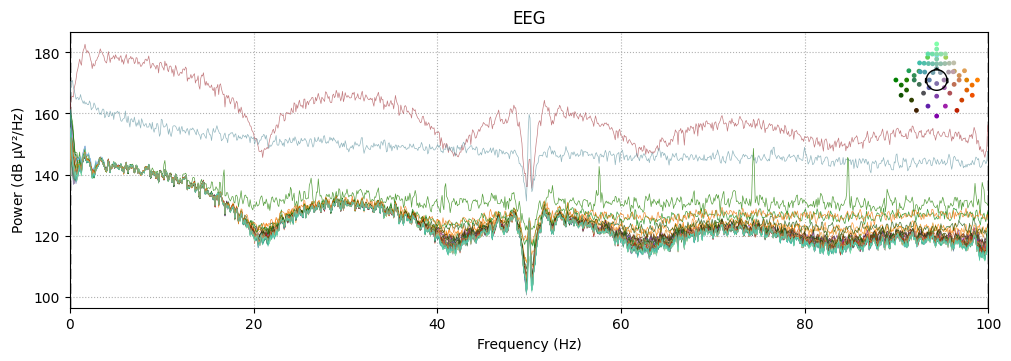

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 49 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 49.00 Hz
- Upper transition bandwidth: 12.25 Hz (-6 dB cutoff frequency: 55.12 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Fitting ICA to data using 62 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 55 components
Fitting ICA took 8.2s.


C:\Users\A ZHAI\AppData\Local\Temp\ipykernel_24816\2873486598.py:36: RuntimeWarning: Using n_components=None (resulting in n_components_=55) may lead to an unstable mixing matrix estimation because the ratio between the largest (61) and smallest (1.3e-05) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 26
  ica.fit(raw)  # 训练raw
C:\Users\A ZHAI\AppData\Local\Temp\ipykernel_24816\2873486598.py:38: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(raw, ica, method='iclabel')
C:\Users\A ZHAI\AppData\Local\Temp\ipykernel_24816\2873486598.py:38: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, 

KeyboardInterrupt: 

In [6]:
if __name__ == '__main__':
    # 配置设置电极信息
    # 读取MNE中biosemi电极位置信息（MNE中的默认电极拓扑）
    # biosemi_montage = mne.channels.make_standard_montage('biosemi64')
    # print(biosemi_montage.get_positions())
    # sensor_data = biosemi_montage.get_positions()['ch_pos']
    # print(sensor_data)
    # sensor_dataframe = pd.DataFrame(sensor_data).T
    # print(sensor_dataframe)
    # sensor_dataframe.to_excel('sensor_dataframe.xlsx')

    # 获取的除ch_pos外的信息
    '''
    'coord_frame': 'unknown', 'nasion': array([ 5.27205792e-18,  8.60992398e-02, -4.01487349e-02]),
    'lpa': array([-0.08609924, -0.        , -0.04014873]), 'rpa': array([ 0.08609924,  0.        , -0.04014873]),
    'hsp': None, 'hpi': None
    '''
    # 将获取的电极位置信息修改并补充缺失的SEED电极位置，整合为1020.xlsx
    data1020 = pd.read_excel('D:\SEED_1020\SEED_1020.xlsx', index_col=0)
    channels1020 = np.array(data1020.index)
    value1020 = np.array(data1020)

    # 将电极通道名称和对应三维坐标位置存储为字典形式
    list_dic = dict(zip(channels1020, value1020))
    print(list_dic)
    # 封装为MNE的格式，参考原biosemi的存储格式
    montage_1020 = mne.channels.make_dig_montage(ch_pos=list_dic,
                                                 nasion=[5.27205792e-18, 8.60992398e-02, -4.01487349e-02],  # 鼻根
                                                 lpa=[-0.08609924, -0., -0.04014873],  # 左耳前突
                                                 rpa=[0.08609924, 0., -0.04014873])  # 右耳前突

    # 图示电极位置
    # montage_1020.plot()
    # plt.show()

    # SEED channel
    ch_names_1 = ['Fp1', 'Fpz', 'Fp2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6'
        , 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5'
        , 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2'
        , 'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7'
        , 'PO5', 'PO3', 'POz', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'Oz', 'O2', 'CB2']

    ch_types_1 = ['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                  'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                  'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                  'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg',
                  'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']

    info = mne.create_info(ch_names=ch_names_1, ch_types=ch_types_1, sfreq=200)
    info.set_montage(montage_1020)

    data_dir = r'D:\SEED_1020\Try'
    experiments = os.listdir(data_dir)
    experiments.sort(key=lambda x:int(x.split('_')[0]))
    #experiments.sort()
    #experiments = experiments[:-2]  # 有两个文件无用
    print('total experiments: {}'.format(len(experiments)))



    preprocess_eeg(0)
    preprocess_eeg(1)